In [1]:
import torch
import pickle

In [2]:
torch.__version__

'2.5.1'

In [3]:
!which python

/Users/rateria/miniconda3/bin/python


In [4]:
from scipy.io import loadmat
from imageio import imread
import numpy as np
import matplotlib.pyplot as plt

import os
import requests
import zipfile
import sys
from glob import glob

In [5]:
# Data directory
DATA_DIR = 'data'
# City Centre Dataset
CITY_DATA_DIR = os.path.join(DATA_DIR, 'city')
CITY_IMGZIP_PATH = os.path.join(CITY_DATA_DIR, 'Images.zip')
CITY_IMG_PATH = os.path.join(CITY_DATA_DIR, 'Images')
CITY_GT_PATH = os.path.join(CITY_DATA_DIR, 'CityCentreGroundTruth.mat')
CITY_IMG_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/Images.zip'
CITY_GT_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/masks/CityCentreGroundTruth.mat'
# New College Dataset
COLLEGE_DATA_DIR = os.path.join(DATA_DIR, 'college')
COLLEGE_IMGZIP_PATH = os.path.join(COLLEGE_DATA_DIR, 'Images.zip')
COLLEGE_IMG_PATH = os.path.join(COLLEGE_DATA_DIR, 'Images')
COLLEGE_GT_PATH = os.path.join(COLLEGE_DATA_DIR, 'NewCollegeGroundTruth.mat')
COLLEGE_IMG_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/Images.zip'
COLLEGE_GT_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/masks/NewCollegeGroundTruth.mat'

def download_file(url, file_name):
    """Downloads a file to destination, skipping download if file exists unless forced.

    Args:
        url: URL of file to download
        file_name: Where to write downloaded file
        force_download: Boolean to force download even if the file exists
    """
    # Ensure destination directory exists
    dest_dir = os.path.dirname(file_name)
    if not os.path.isdir(dest_dir):
        os.makedirs(dest_dir)

    with open(file_name, 'wb') as f:
        print('Downloading {} from {}'.format(file_name, url))
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None:  # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                # Output progress
                complete = dl / total_length
                done = int(50 * complete)
                sys.stdout.write('\r[{}{}] {:6.2f}%'.format('=' * done, ' ' * (50 - done), complete * 100))
                sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()

In [6]:
def get_dataset(name, debug=False):
    debug_amt = 25
    if name.lower() == 'city':  # city centre dataset
        print('Loading the City Centre dataset...')
        # Load images
        print('Loading images')
        if not os.path.isfile(CITY_IMGZIP_PATH):
            download_file(CITY_IMG_URL, CITY_IMGZIP_PATH)
        if not os.path.isdir(CITY_IMG_PATH):
            # Unzip archive
            print('Unzipping {} to {}'.format(CITY_IMGZIP_PATH, CITY_DATA_DIR))
            with zipfile.ZipFile(CITY_IMGZIP_PATH, 'r') as zip_handle:
                zip_handle.extractall(CITY_DATA_DIR)
        # Sort by image number
        img_names = sorted(glob(os.path.join(CITY_IMG_PATH, '*.jpg')))
        assert len(img_names) == 2474
        if debug:
            print('Using fewer images ({}) per debug flag...'.format(
                debug_amt))
            img_names = img_names[:debug_amt]
        imgs = np.asarray([imread(img) for img in img_names])
        # Load GT
        if not os.path.isfile(CITY_GT_PATH):
            download_file(CITY_GT_URL, CITY_GT_PATH)
        print('Loading ground truth')
        gt = loadmat(CITY_GT_PATH)['truth']
        if debug:
            gt = gt[:debug_amt, :debug_amt]
            
    elif name.lower() == 'college':  # new college dataset
        print('Loading the New College dataset...')
        # Load images
        print('Loading images')
        if not os.path.isfile(COLLEGE_IMGZIP_PATH):
            download_file(COLLEGE_IMG_URL, COLLEGE_IMGZIP_PATH)
        if not os.path.isdir(COLLEGE_IMG_PATH):
            # Unzip archive
            print('Unzipping {} to {}'.format(COLLEGE_IMGZIP_PATH,
                                              COLLEGE_DATA_DIR))
            with zipfile.ZipFile(COLLEGE_IMGZIP_PATH, 'r') as zip_handle:
                zip_handle.extractall(COLLEGE_DATA_DIR)
        # Sort by image number
        img_names = sorted(glob(os.path.join(COLLEGE_IMG_PATH, '*.jpg')))
        assert len(img_names) == 2146
        if debug:
            print('Using fewer images ({}) per debug flag...'.format(
                debug_amt))
            img_names = img_names[:debug_amt]
        imgs = np.asarray([imread(img) for img in img_names])
        # Load GT
        if not os.path.isfile(COLLEGE_GT_PATH):
            download_file(COLLEGE_GT_URL, COLLEGE_GT_PATH)
        print('Loading ground truth')
        gt = loadmat(COLLEGE_GT_PATH)['truth']
        if debug:
            gt = gt[:debug_amt, :debug_amt]
    elif name.lower() == 'tsukuba':  # new tsukuba dataset
        raise NotImplementedError
    else:
        raise ValueError('Invalid dataset name: {}.'.format(name))
    return imgs, gt

In [7]:
imgs, gt = get_dataset("college")
print(f"Loaded imgs: {imgs.shape}, gt: {gt.shape}")

Loading the New College dataset...
Loading images


/var/folders/sn/h8k80m7j0wx704gsf17nmqmm0000gn/T/ipykernel_28634/1933293696.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.asarray([imread(img) for img in img_names])


Loading ground truth
Loaded imgs: (2146, 480, 640, 3), gt: (2146, 2146)


In [9]:
np.unique(gt)

array([0, 1], dtype=uint8)

Visualize some images and the ground truth matrix

In [10]:
def plot_image_grid(images, grid_size=(1, 5)):
    fig, axes = plt.subplots(*grid_size, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

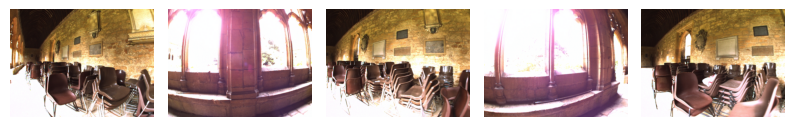

In [11]:
plot_image_grid(imgs[:5])

In [12]:
def plot_ground_truth_matrix(matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, cmap="binary", interpolation="nearest")
    plt.colorbar(label="Loop Closure (1: Closed, 0: Open)")
    plt.title("Ground Truth Matrix for Loop Closures")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()

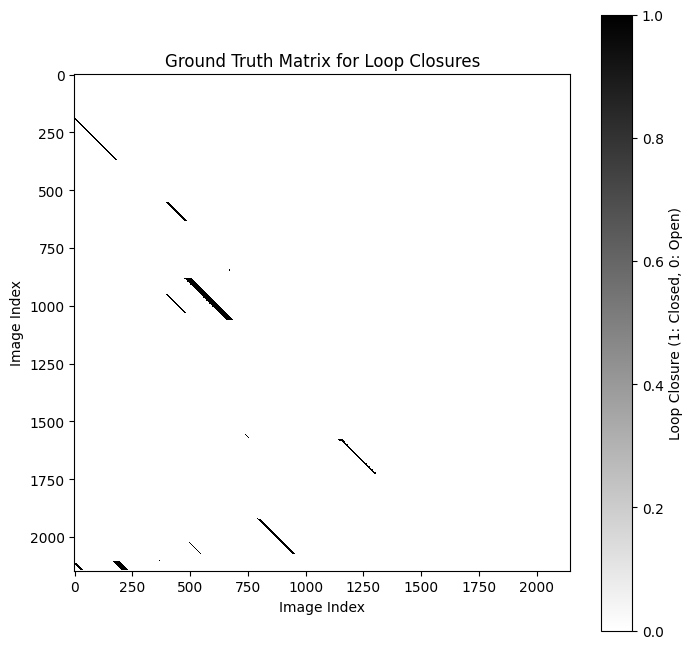

In [13]:
plot_ground_truth_matrix(gt)

Load a CNN and pass the images to get an embedding

## Resnet

In [115]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models

# Load a pre-trained model (e.g., ResNet50) and remove the final layer
model = models.resnet34(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
model.eval()  # Set the model to evaluation mode

# Define a preprocessing function that matches the model's input requirements
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Import Inception v3
# model = models.inception_v3(pretrained=True)
# Remove the auxiliary and final classification layers
# model.aux_logits = False
# model = torch.nn.Sequential(*list(model.children())[:-1])
# model.eval()

# Define preprocessing for Inception v3
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(299),  # Inception v3 expects 299x299 input
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # These values work for Inception too
# ])

def get_image_embedding(image_array, model):
    """
    Passes an image (as a NumPy array) through a pre-trained CNN and returns the final embedding.

    Args:
        image_array (np.ndarray): Input image as a NumPy array.
        model (torch.nn.Module): Pre-trained CNN model without the classification layer.

    Returns:
        torch.Tensor: Final feature embedding of shape (1, 2048) for ResNet50.
    """
    # Check if the NumPy array is in the correct format (H, W, C)
    if image_array.ndim != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image_array should be in H x W x C format with 3 color channels")

    # Convert NumPy array to PIL image and preprocess
    image_tensor = preprocess(image_array).unsqueeze(0)  # Add batch dimension
    
    # Pass through the model to get the embedding
    with torch.no_grad():
        embedding = model(image_tensor)
    
    # Flatten the embedding to a 1D vector
    embedding = embedding.view(embedding.size(0), -1)
    
    return embedding

# Example usage (replace 'image_array' with your actual NumPy image)
image_array = (np.random.rand(224, 224, 3)).astype('uint8') # Example RGB image
embedding = get_image_embedding(image_array, model)
print("Embedding shape:", embedding.shape)

/Users/rateria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rateria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Embedding shape: torch.Size([1, 512])


## VGG

In [14]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models

# Load a pre-trained VGG16 model and remove the final classification layer
model = models.vgg16(pretrained=True)
model = torch.nn.Sequential(*list(model.features.children()))  # Keep only the feature extractor part
model.eval()  # Set the model to evaluation mode

# Define a preprocessing function that matches the model's input requirements
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embedding(image_array, model):
    """
    Passes an image (as a NumPy array) through a pre-trained CNN and returns the final embedding.

    Args:
        image_array (np.ndarray): Input image as a NumPy array.
        model (torch.nn.Module): Pre-trained CNN model without the classification layer.

    Returns:
        torch.Tensor: Final feature embedding of shape (1, 512 * 7 * 7) for VGG16.
    """
    # Check if the NumPy array is in the correct format (H, W, C)
    if image_array.ndim != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image_array should be in H x W x C format with 3 color channels")

    # Convert NumPy array to PIL image and preprocess
    image_tensor = preprocess(image_array).unsqueeze(0)  # Add batch dimension
    
    # Pass through the model to get the embedding
    with torch.no_grad():
        embedding = model(image_tensor)
    
    # Flatten the embedding to a 1D vector
    embedding = embedding.view(embedding.size(0), -1)
    
    return embedding

# Example usage (replace 'image_array' with your actual NumPy image)
# image_array = np.random.rand(224, 224, 3)  # Example RGB image
# embedding = get_image_embedding(image_array, model)
# print("Embedding shape:", embedding.shape)


/Users/rateria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
np.transpose(imgs[0], (2, 0, 1)).shape

(3, 480, 640)

In [18]:
# sanity check
get_image_embedding(imgs[0], model)

tensor([[1.0079e+00, 4.3899e-01, 4.9953e-01, 3.1358e-01, 6.7923e-01, 1.3620e-01,
         2.9184e-02, 6.2206e-01, 1.5768e-01, 5.6780e-02, 4.3766e-01, 1.5035e+00,
         5.8456e-01, 6.8857e-01, 1.0770e+00, 2.4277e+00, 1.1631e+00, 1.4181e-01,
         7.4619e-01, 3.2324e-01, 1.4379e+00, 2.9271e-01, 2.7834e-01, 3.5369e-02,
         1.7021e-01, 1.4698e+00, 3.1322e-01, 3.2754e-01, 4.0494e-01, 5.2849e-01,
         3.1498e-01, 3.1438e-01, 1.8125e-01, 9.2794e-01, 6.6598e-01, 4.2464e-01,
         8.5633e-02, 1.4570e+00, 2.8743e-01, 1.9507e-01, 1.9737e-01, 9.6863e-02,
         1.0558e+00, 3.1291e-01, 1.0016e+00, 1.3831e-01, 5.9027e-02, 2.8457e+00,
         2.8185e-01, 8.8318e-02, 5.6176e-01, 6.6995e-01, 8.9671e-02, 2.8496e-01,
         5.8131e-01, 2.6706e-01, 1.6523e-01, 1.4350e+00, 7.4083e-01, 6.0908e-01,
         1.3329e-02, 8.1780e-01, 1.5209e+00, 1.4891e+00, 7.0428e-01, 7.9745e-01,
         1.3134e-01, 4.0205e-01, 1.0956e-01, 5.3120e-01, 1.6737e-01, 3.9368e-01,
         4.8270e-01, 2.3574e

## Data Processing for feature matching

In [14]:
from sklearn.model_selection import train_test_split

In [16]:
# Define the pickle file path
pickle_file = './data/embeddings_resnet34.pkl'

# Check if the pickle file exists
if os.path.exists(pickle_file):
    # Load data from the pickle file
    with open(pickle_file, 'rb') as f:
        embeddings = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    # Execute some code to generate data
    embeddings = [get_image_embedding(img, model) for img in imgs]
    print("Data generated.")

    # Save data to the pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(embeddings, f)
    print("Data saved to pickle file.")

Data loaded from pickle file.


In [17]:
embeddings = np.array([embedding.numpy() for embedding in embeddings]).reshape(len(imgs), -1)
embeddings.shape

(2146, 512)

In [118]:
def pca_red(descs, dim, eps=1e-5, whiten=True):
    """ Performs PCA + whitening on image descriptors

    Args:
        descs:  input matrix of image descriptors
        dim:    the number of principal components to reduce descs to
        eps:    small epsilon to avoid 0-division
        whiten: whether to whiten the principal components
        cache:  PCA cache (see name parameter)
        name:   used to differentiate different cached value between models

    Returns:
        descs:  the descs post-reduction
        cache:  the (updated) cache
    """
    # Zero-center data
    dmean = descs.mean(axis=0)
    descs = descs - dmean
    # Compute covariance matrix
    cov = descs.T.dot(descs) / (descs.shape[0] - 1)
    # Apply SVD
    U, S, W = np.linalg.svd(cov)

    # Project onto principal axes
    descs = descs.dot(U[:, :dim])
    # Whiten
    if whiten:
        descs = descs / np.sqrt(S[:dim] + eps)
    return descs, S

In [119]:
# sanity check
pca, S = pca_red(np.array(embeddings[:10]).reshape(10, -1), 32)

In [120]:
pca.shape

(10, 32)

Calculate and store the PCA

In [121]:
# L2 Norm
# embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [122]:
# embeddings.reshape(embeddings.shape[0], -1)[0]

In [18]:
# Define the pickle file path
pickle_file = './data/pca_resnet_34.pkl'
pca_dim = 256

# Check if the pickle file exists
if os.path.exists(pickle_file):
    # Load data from the pickle file
    with open(pickle_file, 'rb') as f:
        pca = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    # Execute some code to generate data
    pca, _ = pca_red(embeddings, pca_dim) 
    print("Data generated.")

    # Save data to the pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(pca, f)
    print("Data saved to pickle file.")

Data loaded from pickle file.


In [19]:
pca.shape

(2146, 256)

### Calc Similarity Matrix

In [125]:
from sklearn.cluster import KMeans

In [126]:
def cluster_kmeans(sim):
    """Run k-means on similarity matrix and segment"""
    sim_dim = sim.shape[0]
    sim = sim.reshape(-1, 1)

    # Augment with spatial coordinates
    sim_aug = np.concatenate(
        [sim,
         np.mgrid[:sim_dim, :sim_dim].reshape(-1, sim_dim ** 2).T],
        axis=1
    )

    # Empirical metric for number of loop-closures given number of images
    # in sequence (assumption: equally-spaced samples):
    n_clusters = int(np.sqrt(sim_dim))
    print('Performing clustering via KMeans(n={}).'.format(n_clusters))

    km = KMeans(n_clusters=n_clusters, max_iter=300)
    labels = km.fit_predict(sim_aug)
    print('Got cluster labels')

    for i in range(n_clusters):
        lab_idx = (labels == i)
        if lab_idx.size:
            cc = sim[lab_idx].mean()
            # cc = sim[lab_idx].max()
            sim[lab_idx] = cc

    # Re-normalize and reshape
    sim = sim.reshape(sim_dim, sim_dim) / sim.max()
    return sim

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity_matrix(descs, gt, median=False, cluster=True, plot=True,
                      k_size=None, name='', threshold=None):
    """ Compute pairwise similarity between descriptors. Using provided gt to find best
    parameters given function args.

    Args:
        descs:   feature descriptors of shape (n, d)
        gt:      the ground truth
        median:  whether to use median filtering (chooses median value that obtains
                 highest avg precision...
        cluster: whether to cluster
        plot:    whether to plot matrix
        k_size:  specify None to sweep, otherwise the value to use
        name:    name for plot file+cache
    """
    print('Computing similarity matrix...')
    n = descs.shape[0]
    diffs = np.zeros((n, n))

    # Compute L2 norm of each vector
    norms = np.linalg.norm(descs, axis=1)
    descs_norm = descs / norms[:, None]

    # sim = np.dot(descs, descs.T)
    # sim = np.inner(descs.T, descs.T) / ((np.linalg.norm(descs, axis=0).reshape(-1,1)) * ((np.linalg.norm(descs, axis=0).reshape(-1,1)).T))
    sim = cosine_similarity(descs)
    # print(max(sim), min(sim))

    # Compute similarity of every vector with every vector
    # for i, desc in enumerate(descs):
    #     # Compute difference
    #     diff = np.linalg.norm(descs_norm - descs_norm[i], axis=1)
    #     diffs[i] = diff

    # # # Compute max difference
    # dmax = diffs.max()

    # # # Normalize difference and create sim matrix
    # sim = 1. - (diffs / dmax)
    print(sim.shape, gt.shape)
    assert gt.shape[0] == sim.shape[0]

    if cluster:
        sim = cluster_kmeans(sim)

    if median:
        # sim = median_filter(sim, gt, k_size=k_size)
        pass
    
    if threshold:
        sim[sim>threshold] = 1
        sim[sim<=threshold] = 0
        
    if plot:
        f, ax = plt.subplots()
        cax = ax.imshow(sim, cmap='coolwarm', interpolation='nearest',
                        vmin=0., vmax=1.)
        cbar = f.colorbar(cax, ticks=[0, 0.5, 1])
        cbar.ax.set_yticklabels(['0', '0.5', '1'])
        plt.savefig('simplot_{}.png'.format(name), format='png', dpi=150)
        plt.show()

        # Preprocess gt...
        gt = gt.copy()
        gt += gt.T  # add transpose
        gt += np.eye(gt.shape[0], dtype=gt.dtype)

        # Plot
        f, ax = plt.subplots(1, 2)
        ax[0].imshow(sim, cmap='coolwarm', interpolation='nearest',
                     vmin=0., vmax=1.)
        ax[0].set_axis_off()
        ax[0].set_title('Similarity Matrix')
        ax[1].imshow(gt, cmap='gray', interpolation='nearest',
                     vmin=0., vmax=1.)
        ax[1].set_axis_off()
        ax[1].set_title('Ground Truth')
        plt.savefig('simplot_w_gt_{}.png'.format(name), format='png', dpi=150)
        plt.show()

    return sim

Computing similarity matrix...
(2146, 2146) (2146, 2146)


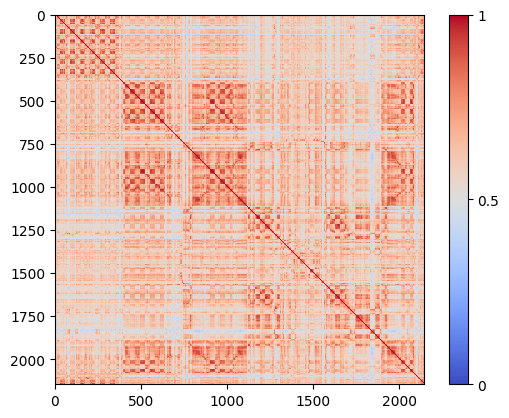

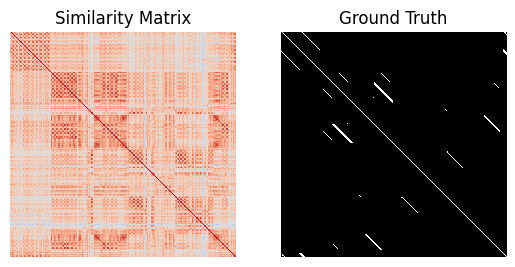

In [24]:
# just the similarity matrix using l2 norm
sim_embeddings = similarity_matrix(embeddings, gt, cluster=False, threshold=None)

Computing similarity matrix...
(2146, 2146) (2146, 2146)


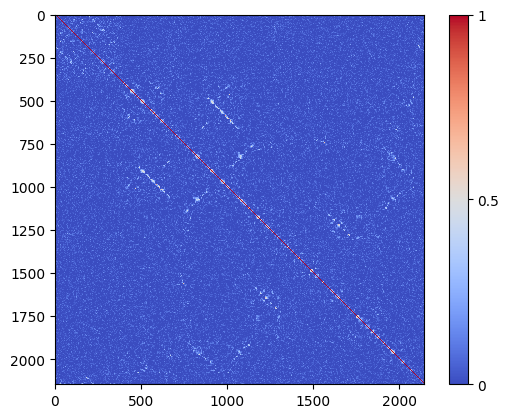

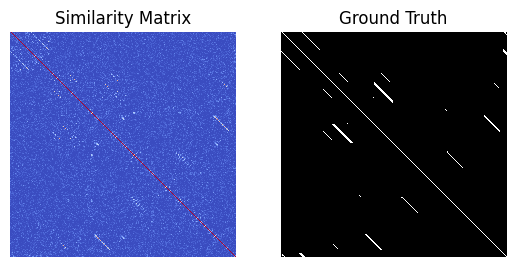

In [25]:
sim_pca = similarity_matrix(pca, gt, cluster=False, threshold=None)

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score

In [41]:
def mean_per_class_accuracy(y_true, y_pred, n_classes=None, labels=None):
    """ Computes mean per-class accuracy

    Args:
        y_true:    the true labels
        y_pred:    the predicted labels
        n_classes: the number of classes, optional. If not provided, the number of
                   unique classes or length of `labels` if provided.
        labels:    the unique labels, optional. If not provided, unique labels are used
                   if `n_classes` not provided, otherwise range(n_classes).

    Returns:
        mean per-class accuracy
    """
    if n_classes is None:
        if labels is None:
            labels = np.unique(y_true)
        n_classes = len(labels)
    elif labels is None:
        labels = np.arange(n_classes)
    elif len(labels) != n_classes:
        raise ValueError('Number of classes specified ({}) differs from '
                         'number of labels ({}).'.format(n_classes, len(labels)))
    acc = 0.
    for c in labels:
        c_mask = (y_true == c)
        c_count = c_mask.sum()
        if c_count:  # Avoid division by 0
            # Add accuracy for class c
            acc += np.logical_and(c_mask, (y_pred == c)).sum() / c_count
    # Mean accuracy per class
    return acc / n_classes


def compute_and_plot_scores(sim, gt, model_name):
    """ Computes relevant metrics and plots results.

    Args:
        sim:        Similarity matrix
        gt:         Ground truth matrix
        model_name: Name of the model for logging
    """
    # Modify sim matrix to get "real" vector of loop-closures
    # symmetric matrix, take either diagonal matrix, rid diagonal
    sim = sim[np.tril_indices(sim.shape[0], -1)]

    # Ground truth only present in lower diagonal for Oxford datasets
    gt = gt[np.tril_indices(gt.shape[0], -1)]

    # Compute PR-curve
    precision, recall, thresholds = precision_recall_curve(gt, sim)
    average_precision = average_precision_score(gt, sim)
    print('Average Precision: {}'.format(average_precision))

    best_macc = 0.
    best_mthresh = None
    # Compute the best MPC-accuracy at hard-coded thresholds
    thresholds = np.arange(0, 1.02, 0.02)
    for thresh in thresholds:
        sim_thresh = np.zeros_like(sim)
        sim_thresh[sim >= thresh] = 1
        macc = mean_per_class_accuracy(gt, sim_thresh, n_classes=2)
        if macc > best_macc:
            best_macc = macc
            best_mthresh = thresh


    best_f1 = 0.0
    best_f1_thresh = None

    # Calculate F1 score for each threshold
    for thresh in thresholds:
        sim_thresh = np.zeros_like(sim)
        sim_thresh[sim >= thresh] = 1
        f1 = f1_score(gt, sim_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_f1_thresh = thresh

    

    sim_mthresh = np.zeros_like(sim)
    sim_mthresh[sim >= best_mthresh] = 1
    precision_at_mthresh = precision_score(gt, sim_mthresh)
    recall_at_mthresh = recall_score(gt, sim_mthresh)
    print('Best MPC-ACC (thresh={}): {}'.format(best_mthresh, best_macc))
    print('Precision (thresh={}): {}'.format(best_mthresh, precision_at_mthresh))
    print('Recall (thresh={}): {}'.format(best_mthresh, recall_at_mthresh))

    sim_f1thresh = np.zeros_like(sim)
    sim_f1thresh[sim >= best_f1_thresh] = 1
    precision_at_f1thresh = precision_score(gt, sim_f1thresh)
    recall_at_f1thresh = recall_score(gt, sim_f1thresh)
    print("Best F1 Score (thresh={}): {}".format(best_f1_thresh, best_f1))
    print('Precision (thresh={}): {}'.format(best_f1_thresh, precision_at_f1thresh))
    print('Recall (thresh={}): {}'.format(best_f1_thresh, recall_at_f1thresh))

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.3f}'.format(
        average_precision))
    plt.savefig('precision-recall_curve_{}.png'.format(model_name),
                format='png', dpi=150)
    plt.show()
    


Average Precision: 0.11229210118931068
Best MPC-ACC (thresh=0.68): 0.7327444198404454
Precision (thresh=0.68): 0.017637268499632864
Recall (thresh=0.68): 0.7287621359223301
Best F1 Score (thresh=0.92): 0.21087060379993383
Precision (thresh=0.92): 0.2317634703934082
Recall (thresh=0.92): 0.19343311758360301


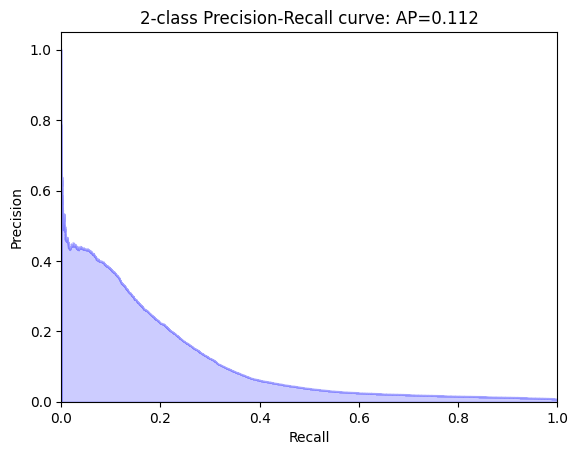

In [133]:
compute_and_plot_scores(sim, gt, "resnet_college_without_pca")

## SSIM

In [26]:
import pandas as pd

In [27]:
df = pd.read_csv("ssim/sim_matrix.csv", header=None)
sim_ssim = df.to_numpy()
sim_ssim_filter = np.where(sim > 0.42, 1, 0)

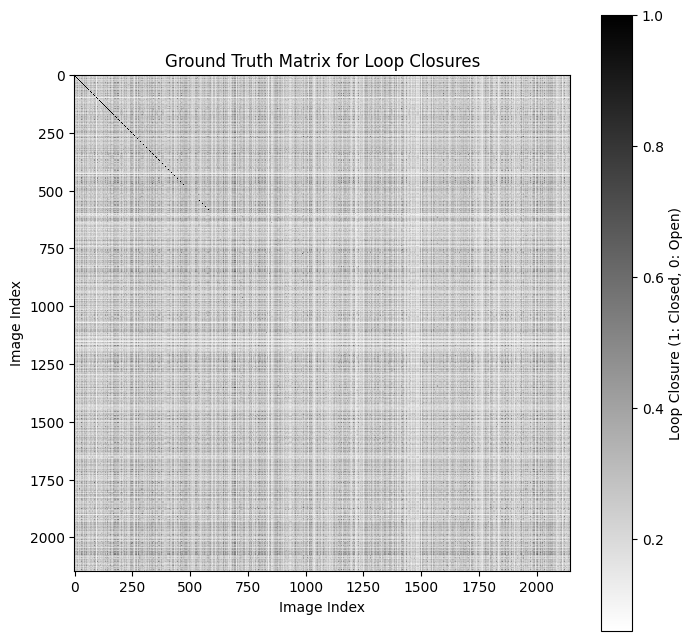

In [29]:
plot_ground_truth_matrix(sim_ssim)

Average Precision: 0.006387668992170665
Best MPC-ACC (thresh=0.42): 0.5005566083654486
Precision (thresh=0.42): 0.00675740164544639
Recall (thresh=0.42): 0.023867313915857606
Best F1 Score (thresh=0.1): 0.012807201520044022
Precision (thresh=0.1): 0.006444955326819583
Recall (thresh=0.1): 0.9979773462783171


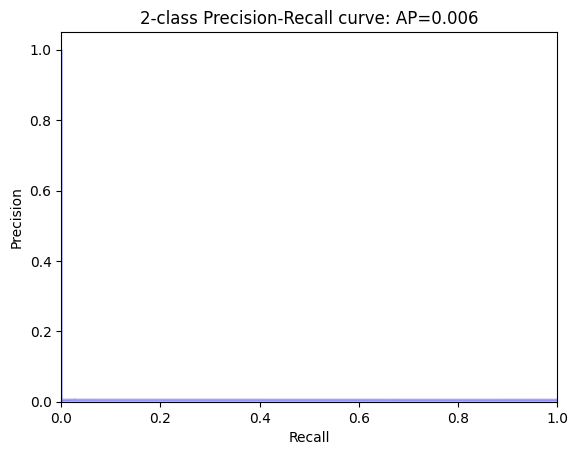

In [137]:
compute_and_plot_scores(sim_ssim, gt, "ssim")

## LPIPS

In [16]:
import lpips
from tqdm import tqdm

# Load pre-trained LPIPS model
loss_fn = lpips.LPIPS(net='alex').to("mps") # You can choose 'vgg' or 'squeeze' as well

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/rateria/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rateria/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/rateria/miniconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/Users/rateria/miniconda3/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loca

In [18]:
loss_fn

LPIPS(
  (scaling_layer): ScalingLayer()
  (net): alexnet(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (slice4): Sequential(
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
    )
    (slice5): Sequential(
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (lin0): NetLinLayer(
    (model): Sequential(
      (0): D

In [22]:
imgs = torch.from_numpy(imgs).to("mps")

In [23]:
imgs.shape

torch.Size([2146, 480, 640, 3])

In [24]:
img_test = torch.tensor(imgs[:2, :, :, :], dtype=torch.float32).permute(0, 3, 1, 2)
img_test.shape

/var/folders/sn/h8k80m7j0wx704gsf17nmqmm0000gn/T/ipykernel_30431/3810887853.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_test = torch.tensor(imgs[:2, :, :, :], dtype=torch.float32).permute(0, 3, 1, 2)


torch.Size([2, 3, 480, 640])

In [26]:
loss_fn(img_test[0], img_test[1]).squeeze().detach().cpu().numpy()

array(0.32865423, dtype=float32)

In [ ]:
similarities = []
n = imgs.shape[0]
for i, img1 in tqdm(enumerate(imgs[:n-1]), total=imgs.shape[0]):
    similarity = []
    img1 = torch.tensor(img1, dtype=torch.float32).permute(2, 0, 1)
    for j, img2 in enumerate(imgs[i+1:]):
        img2 = torch.tensor(img2, dtype=torch.float32).permute(2, 0, 1)
        val = loss_fn(img1, img2).squeeze().detach().cpu().numpy()
        similarity.append(val)
    similarities.append(similarity)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import torch

def compute_similarity(index_pair):
    i, j = index_pair
    img1 = torch.tensor(imgs[i], dtype=torch.float32).permute(2, 0, 1)
    img2 = torch.tensor(imgs[j], dtype=torch.float32).permute(2, 0, 1)
    return i, j, loss_fn(img1, img2).squeeze().detach().cpu().numpy()

# Flatten the index pairs for parallel computation
index_pairs = [(i, j) for i in range(n-1) for j in range(i+1, n)]

similarities = [[] for _ in range(n-1)]

# Use ThreadPoolExecutor for parallelism
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm(executor.map(compute_similarity, index_pairs), total=len(index_pairs)))

# Populate the similarities list
for i, j, similarity in results:
    similarities[i].append(similarity)

In [30]:
combined_similarities = np.load("./normalized_lower_triangle_matrix.npy")

In [31]:
sim_lpips = 1-combined_similarities
np.max(1-combined_similarities)

np.float64(1.0)

Average Precision: 0.0962305274002551
Best MPC-ACC (thresh=0.32): 0.710345664480609
Precision (thresh=0.32): 0.017045522557786
Recall (thresh=0.32): 0.6720604099244876
Best F1 Score (thresh=0.54): 0.192318474908887
Precision (thresh=0.54): 0.20023350846468185
Recall (thresh=0.54): 0.18500539374325783


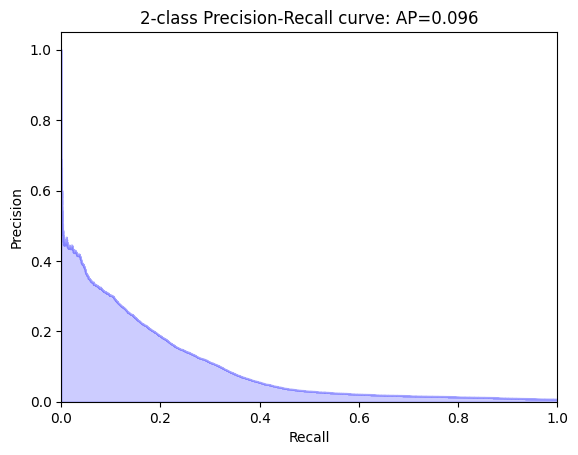

In [42]:
compute_and_plot_scores(sim_lpips, gt, "lpips")

## K-means

In [39]:
# Define the pickle file path
pickle_file = './data/embeddings_resnet34.pkl'

# Check if the pickle file exists
if os.path.exists(pickle_file):
    # Load data from the pickle file
    with open(pickle_file, 'rb') as f:
        embeddings = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    # Execute some code to generate data
    embeddings = [get_image_embedding(img, model) for img in imgs]
    print("Data generated.")

    # Save data to the pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(embeddings, f)
    print("Data saved to pickle file.")

Data loaded from pickle file.


In [40]:
embeddings = np.array([embedding.numpy() for embedding in embeddings]).reshape(len(imgs), -1)
embeddings.shape

(2146, 512)

In [42]:
# balance
n = gt.shape[0]
pairs = [(i, j, gt[i, j]) for i in range(1, n) for j in range(i)]

positive_pairs = [(i, j) for i, j, s in pairs if s == 1]
negative_pairs = [(i, j) for i, j, s in pairs if s == 0]

min_size = min(len(positive_pairs), len(negative_pairs))
balanced_positive_pairs = positive_pairs[:min_size]
balanced_negative_pairs = negative_pairs[:min_size]
balanced_pairs = balanced_positive_pairs + balanced_negative_pairs

X = np.array(balanced_pairs)
y = np.array([1] * min_size + [0] * min_size)  # Labels for the balanced dataset


In [43]:
X.shape, y.shape

((29664, 2), (29664,))

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-Means
n_clusters = 2  # Number of clusters to group similar images
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

print("Cluster Assignments:", clusters)

Cluster Assignments: [0 0 0 ... 0 0 0]


In [36]:
len(clusters)

2146

In [37]:
# Create a similarity matrix based on cluster assignments
n_samples = len(clusters)
similarity_matrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(n_samples):
        # Similarity is 1 if images are in the same cluster, otherwise 0
        similarity_matrix[i, j] = int(clusters[i] == clusters[j])


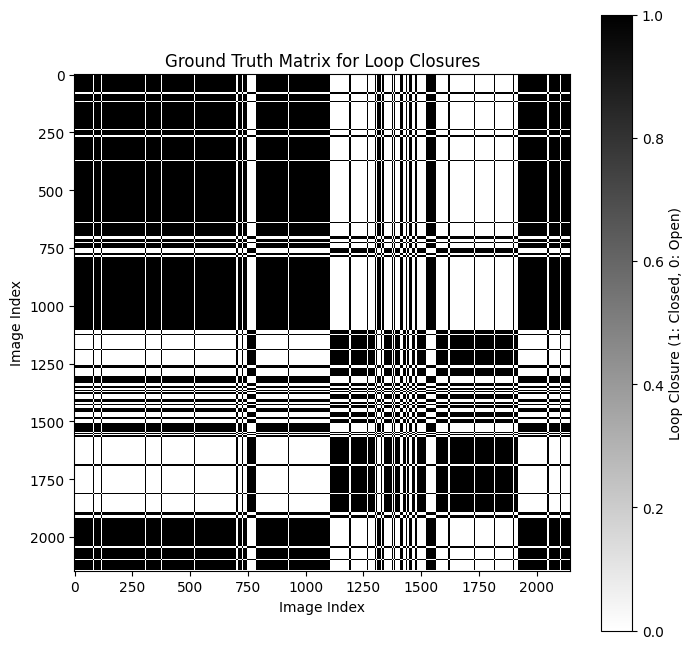

In [40]:
plot_ground_truth_matrix(similarity_matrix)

Average Precision: 0.010971988441427064
Best MPC-ACC (thresh=0.02): 0.7038818596441737
Precision (thresh=0.02): 0.011175836947586245
Recall (thresh=0.02): 0.9569174757281553
Best F1 Score (thresh=0.02): 0.022093642298747513
Precision (thresh=0.02): 0.011175836947586245
Recall (thresh=0.02): 0.9569174757281553


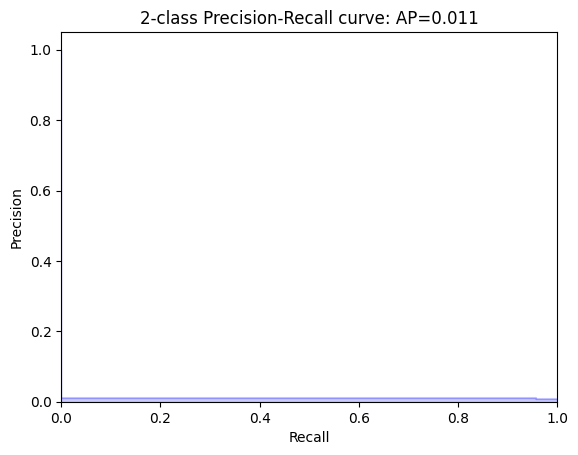

In [44]:
compute_and_plot_scores(similarity_matrix, gt, "kmeans")

In [33]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# Compute RBF kernel (similarity matrix)
gamma = 0.01  # Adjust gamma based on your data
sim_rbf = rbf_kernel(embeddings, embeddings, gamma=gamma)

print("RBF Kernel Similarity Matrix:")
print(sim_rbf)

RBF Kernel Similarity Matrix:
[[1.         0.00341099 0.11807137 ... 0.005756   0.00639132 0.00255344]
 [0.00341099 1.         0.00132719 ... 0.02240806 0.00991255 0.01647048]
 [0.11807137 0.00132719 1.         ... 0.00326902 0.00155561 0.00196545]
 ...
 [0.005756   0.02240806 0.00326902 ... 1.         0.00746261 0.38671982]
 [0.00639132 0.00991255 0.00155561 ... 0.00746261 1.         0.00455086]
 [0.00255344 0.01647048 0.00196545 ... 0.38671982 0.00455086 1.        ]]


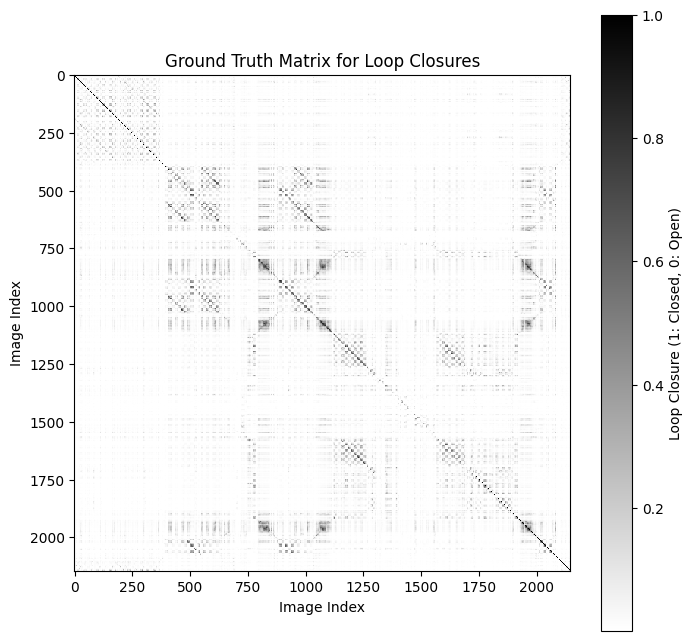

In [34]:
plot_ground_truth_matrix(sim_rbf)

Average Precision: 0.09354463005329514
Best MPC-ACC (thresh=0.04): 0.6848642603295129
Precision (thresh=0.04): 0.02783372002182729
Recall (thresh=0.04): 0.4780204962243797
Best F1 Score (thresh=0.34): 0.19537614678899082
Precision (thresh=0.34): 0.21436624255113546
Recall (thresh=0.34): 0.17947680690399137


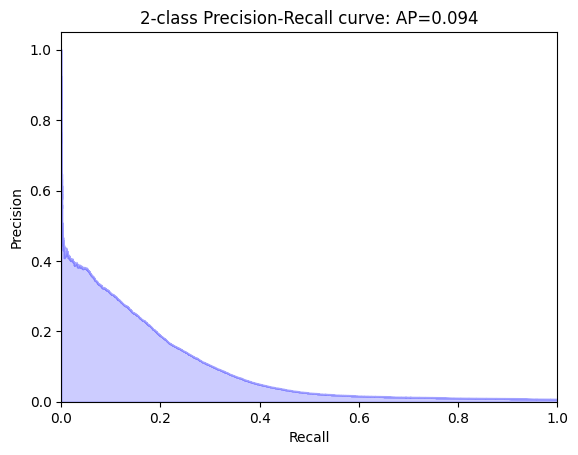

In [68]:
compute_and_plot_scores(sim_rbf, gt, "rbf")

## Neural Network Time

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

In [44]:
num_images = embeddings.shape[0]
embedding_dim = embeddings.shape[1]

In [45]:
# Generate pairs and labels from the ground truth matrix
def generate_pairs_from_matrix(embeddings, ground_truth_matrix):
    pairs, pair_labels = [], []
    num_images = embeddings.shape[0]
    for i in range(num_images):
        for j in range(i):  # Only consider lower triangular part (j < i)
            pairs.append((torch.tensor(embeddings[i], dtype=torch.float32), torch.tensor(embeddings[j], dtype=torch.float32)))
            pair_labels.append(ground_truth_matrix[i, j])  # Label based on matrix
    return pairs, pair_labels

pairs, pair_labels = generate_pairs_from_matrix(embeddings, gt)

In [46]:
len(pair_labels), len(pairs)

(2301585, 2301585)

In [47]:
pairs = torch.stack([torch.cat([x[0], x[1]]) for x in pairs])  # Concatenate pairs
pair_labels = torch.tensor(pair_labels)

In [48]:
len(pair_labels), len(pairs)

(2301585, 2301585)

In [49]:
# # Split into train/test sets
# train_data, test_data, train_labels, test_labels = train_test_split(
#     pairs, pair_labels, test_size=0.2, random_state=42
# )

In [50]:
from collections import Counter
# Balance the dataset
def balance_classes(pairs, pair_labels):
    # Separate samples by class
    label_counts = Counter(pair_labels.numpy())
    num_class_1 = label_counts[1]
    num_class_0 = label_counts[0]

    # Find indices of each class
    indices_1 = [i for i, label in enumerate(pair_labels) if label == 1]
    indices_0 = [i for i, label in enumerate(pair_labels) if label == 0]

    # Undersample the majority class to match the minority class
    balanced_indices_0 = np.random.choice(indices_0, size=num_class_1, replace=False)
    balanced_indices = np.concatenate([indices_1, balanced_indices_0])

    # Shuffle and select balanced samples
    np.random.shuffle(balanced_indices)
    balanced_pairs = pairs[balanced_indices]
    balanced_labels = pair_labels[balanced_indices]

    return balanced_pairs, balanced_labels

balanced_pairs, balanced_labels = balance_classes(pairs, pair_labels)

In [51]:
print(balanced_labels.shape, balanced_pairs.shape)

torch.Size([29664]) torch.Size([29664, 1024])


In [52]:
# Split into train/val/test sets
train_data, val_test_data, train_labels, val_test_labels = train_test_split(
    balanced_pairs, balanced_labels, test_size=0.3, random_state=42
)
val_data, test_data, val_labels, test_labels = train_test_split(
    val_test_data, val_test_labels, test_size=0.5, random_state=42
)

In [77]:
# Neural Network Model
class SimilarityNN(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
class SimilarityNN1(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityNN1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x
    
class SimilarityNN2(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityNN2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc15 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc25 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc15(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc25(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Training Loop
def train(model, num_epochs=100):
    # Model, Loss, Optimizer
    # model = SimilarityNN(input_dim=embedding_dim * 2)  # 2 * embedding_dim because embeddings are concatenated
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.0009)

    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_data.float()).squeeze()
        loss = criterion(outputs, train_labels.float())
        train_losses.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        
        accuracy = (outputs.round() == train_labels).sum().item() / len(train_labels)
        train_acc.append(accuracy)
        
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data.float()).squeeze()
            val_loss = criterion(val_outputs, val_labels.float())
            val_losses.append(val_loss.detach().cpu())
            accuracy = (val_outputs.round() == val_labels).sum().item() / len(val_labels)
            val_acc.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return model, train_losses, val_losses, train_acc, val_acc


In [78]:
model = SimilarityNN(input_dim=embedding_dim * 2) 
model1 = SimilarityNN1(input_dim=embedding_dim * 2) 
model2 = SimilarityNN2(input_dim=embedding_dim * 2) 

In [79]:
model, train_losses, test_losses, train_acc, val_acc = train(model, 300)
model1, train_losses1, test_losses1, train_acc1, val_acc1 = train(model1, 300)
model2, train_losses2, test_losses2, train_acc2, val_acc2 = train(model2, 300)

Epoch 1/300, Loss: 0.6944, Val Loss: 0.6714
Epoch 2/300, Loss: 0.6705, Val Loss: 0.6505
Epoch 3/300, Loss: 0.6506, Val Loss: 0.6301
Epoch 4/300, Loss: 0.6292, Val Loss: 0.6124
Epoch 5/300, Loss: 0.6098, Val Loss: 0.5940
Epoch 6/300, Loss: 0.5912, Val Loss: 0.5787
Epoch 7/300, Loss: 0.5759, Val Loss: 0.5677
Epoch 8/300, Loss: 0.5636, Val Loss: 0.5572
Epoch 9/300, Loss: 0.5531, Val Loss: 0.5483
Epoch 10/300, Loss: 0.5440, Val Loss: 0.5406
Epoch 11/300, Loss: 0.5354, Val Loss: 0.5317
Epoch 12/300, Loss: 0.5269, Val Loss: 0.5231
Epoch 13/300, Loss: 0.5186, Val Loss: 0.5154
Epoch 14/300, Loss: 0.5103, Val Loss: 0.5070
Epoch 15/300, Loss: 0.5022, Val Loss: 0.4993
Epoch 16/300, Loss: 0.4946, Val Loss: 0.4926
Epoch 17/300, Loss: 0.4874, Val Loss: 0.4852
Epoch 18/300, Loss: 0.4804, Val Loss: 0.4786
Epoch 19/300, Loss: 0.4737, Val Loss: 0.4725
Epoch 20/300, Loss: 0.4674, Val Loss: 0.4661
Epoch 21/300, Loss: 0.4613, Val Loss: 0.4601
Epoch 22/300, Loss: 0.4547, Val Loss: 0.4536
Epoch 23/300, Loss:

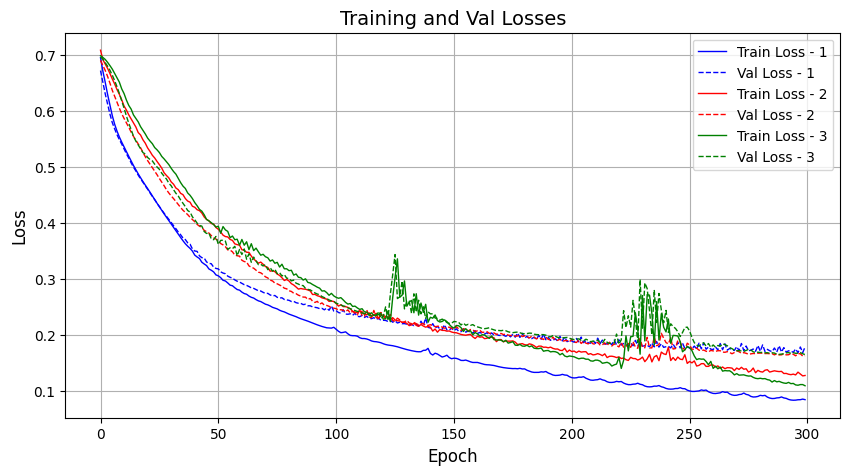

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss - 1', color='blue', linestyle='-', linewidth=1)
plt.plot(test_losses, label='Val Loss - 1', color='blue', linestyle='--', linewidth=1)
plt.plot(train_losses1, label='Train Loss - 2', color='red', linestyle='-', linewidth=1)
plt.plot(test_losses1, label='Val Loss - 2', color='red', linestyle='--', linewidth=1)
plt.plot(train_losses2, label='Train Loss - 3', color='green', linestyle='-', linewidth=1)
plt.plot(test_losses2, label='Val Loss - 3', color='green', linestyle='--', linewidth=1)
plt.title(f'Training and Val Losses', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

In [82]:
!pip install torchinfo

In [85]:
train_data.shape

torch.Size([20764, 1024])

In [83]:
from torchinfo import summary

In [90]:
summary(model2, input_size=(512, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
SimilarityNN2                            [512, 1]                  --
├─Linear: 1-1                            [512, 128]                131,200
├─ReLU: 1-2                              [512, 128]                --
├─Linear: 1-3                            [512, 64]                 8,256
├─ReLU: 1-4                              [512, 64]                 --
├─Dropout: 1-5                           [512, 64]                 --
├─Linear: 1-6                            [512, 32]                 2,080
├─ReLU: 1-7                              [512, 32]                 --
├─Linear: 1-8                            [512, 16]                 528
├─ReLU: 1-9                              [512, 16]                 --
├─Dropout: 1-10                          [512, 16]                 --
├─Linear: 1-11                           [512, 1]                  17
├─Sigmoid: 1-12                          [512, 1]                  --
Tot

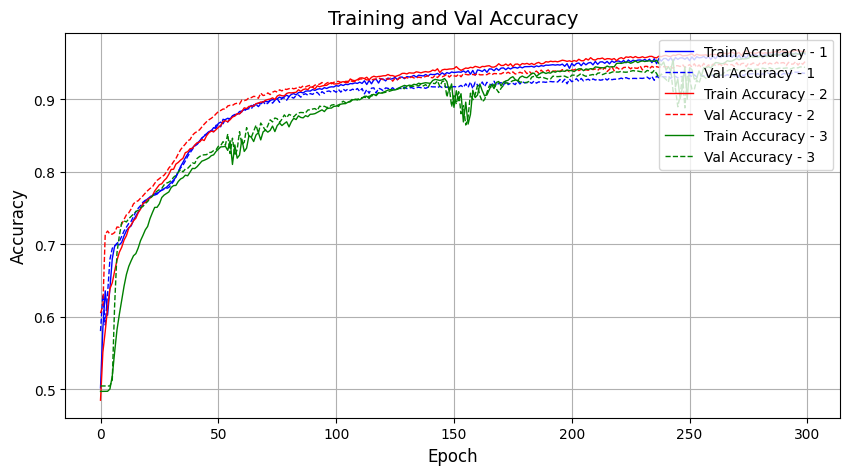

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy - 1', color='blue', linestyle='-', linewidth=1)
plt.plot(val_acc, label='Val Accuracy - 1', color='blue', linestyle='--', linewidth=1)
plt.plot(train_acc1, label='Train Accuracy - 2', color='red', linestyle='-', linewidth=1)
plt.plot(val_acc1, label='Val Accuracy - 2', color='red', linestyle='--', linewidth=1)
plt.plot(train_acc2, label='Train Accuracy - 3', color='green', linestyle='-', linewidth=1)
plt.plot(val_acc2, label='Val Accuracy - 3', color='green', linestyle='--', linewidth=1)
plt.title(f'Training and Val Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

In [63]:
def get_metrics(model):
    with torch.no_grad():
        test_outputs = model(test_data.float()).squeeze()

    predicted_labels = test_outputs.round()
    precision = precision_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    accuracy = (test_outputs.round() == test_labels).sum().item() / len(test_labels)
    accuracy_percentage = accuracy * 100
    print(f"Accuracy: {accuracy_percentage:.2f}%\n")

In [64]:
get_metrics(model)
get_metrics(model1)
get_metrics(model2)

Precision: 0.9221635883905013
Recall: 0.9579716765646414
Accuracy: 93.96%

Precision: 0.9182712879760376
Recall: 0.9803563270899954
Accuracy: 94.74%

Precision: 0.9150214592274678
Recall: 0.9739607126541799
Accuracy: 94.27%




Epoch: 50
Epoch 1/50, Loss: 0.6905, Val Loss: 0.6706
Epoch 2/50, Loss: 0.6713, Val Loss: 0.6509
Epoch 3/50, Loss: 0.6508, Val Loss: 0.6316
Epoch 4/50, Loss: 0.6308, Val Loss: 0.6131
Epoch 5/50, Loss: 0.6114, Val Loss: 0.5956
Epoch 6/50, Loss: 0.5929, Val Loss: 0.5819
Epoch 7/50, Loss: 0.5779, Val Loss: 0.5699
Epoch 8/50, Loss: 0.5649, Val Loss: 0.5589
Epoch 9/50, Loss: 0.5530, Val Loss: 0.5491
Epoch 10/50, Loss: 0.5424, Val Loss: 0.5403
Epoch 11/50, Loss: 0.5331, Val Loss: 0.5318
Epoch 12/50, Loss: 0.5240, Val Loss: 0.5229
Epoch 13/50, Loss: 0.5149, Val Loss: 0.5140
Epoch 14/50, Loss: 0.5059, Val Loss: 0.5053
Epoch 15/50, Loss: 0.4976, Val Loss: 0.4970
Epoch 16/50, Loss: 0.4899, Val Loss: 0.4892
Epoch 17/50, Loss: 0.4826, Val Loss: 0.4812
Epoch 18/50, Loss: 0.4752, Val Loss: 0.4736
Epoch 19/50, Loss: 0.4679, Val Loss: 0.4660
Epoch 20/50, Loss: 0.4611, Val Loss: 0.4595
Epoch 21/50, Loss: 0.4546, Val Loss: 0.4523
Epoch 22/50, Loss: 0.4485, Val Loss: 0.4470
Epoch 23/50, Loss: 0.4428, Val

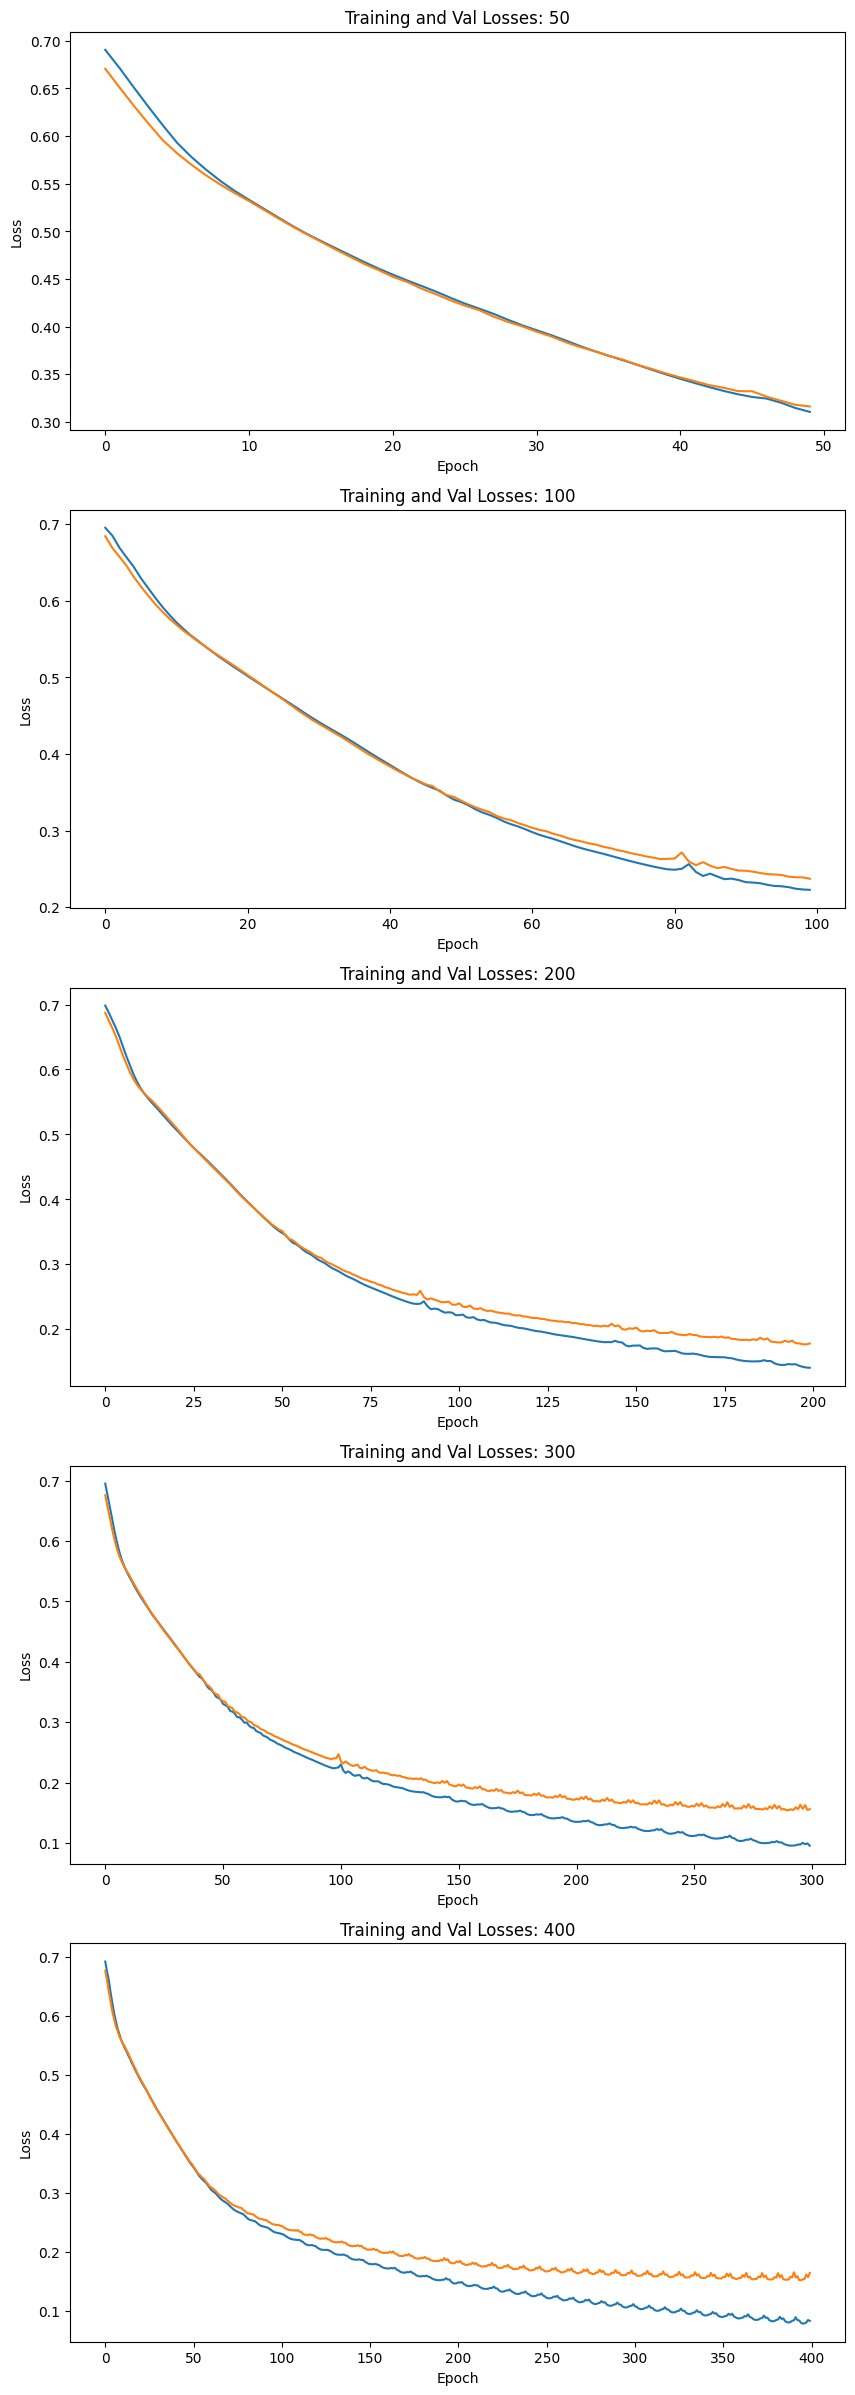

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [128]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

epochs = [50, 100, 200, 300, 400]

fig, axs = plt.subplots(len(epochs), figsize=(10, 30))

for i, epoch in enumerate(epochs):
    print(f"\nEpoch: {epoch}")
    model, train_losses, test_losses = train(epoch)
    plt.figure(figsize=(10, 5))
    axs[i].plot(train_losses, label='Train Loss')
    axs[i].plot(test_losses, label='Test Loss')
    axs[i].set_title(f'Training and Val Losses: {epoch}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    
    with torch.no_grad():
        test_outputs = model(test_data.float()).squeeze()
    
    predicted_labels = test_outputs.round()
    precision = precision_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    accuracy = (test_outputs.round() == test_labels).sum().item() / len(test_labels)
    accuracy_percentage = accuracy * 100
    print(f"Accuracy: {accuracy_percentage:.2f}%")

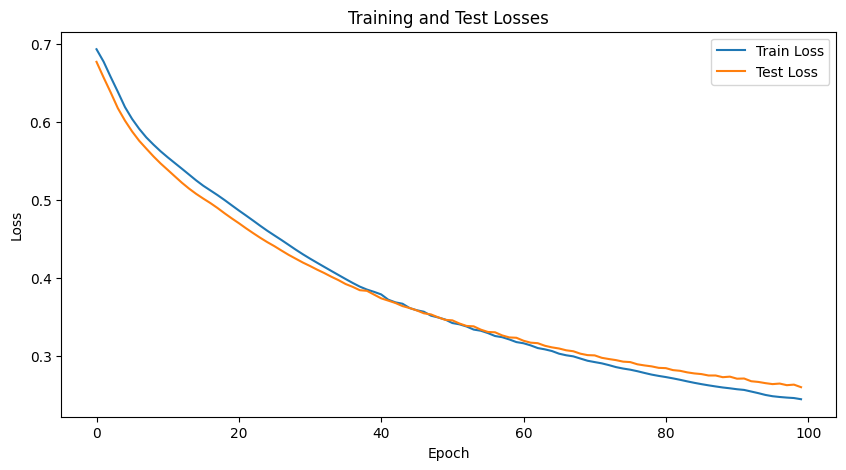

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [102]:
with torch.no_grad():
    test_outputs = model2(test_data.float()).squeeze()

In [103]:
test_outputs.shape

torch.Size([4450])

In [104]:
test_labels.shape

torch.Size([4450])

Precision: 0.92
Recall: 0.96
Accuracy: 94.18%


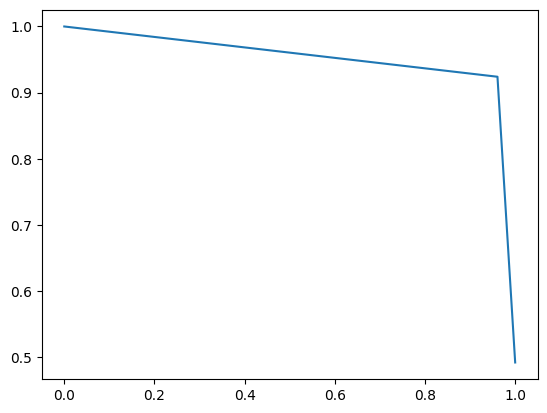

In [105]:
from sklearn.metrics import precision_score, recall_score, auc

predicted_labels = test_outputs.round()
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

accuracy = (test_outputs.round() == test_labels).sum().item() / len(test_labels)
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, predicted_labels)

# Compute AUC
auc_score = auc(recall, precision)

# Plot the Precision-Recall curve
plt.plot(recall, precision, label=f'mlp (AUC={auc_score:.2f})')


In [55]:
precision_score([1,1,1], [0,0,0])

/Users/rateria/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.0)

In [57]:
max(test_labels)

tensor(1, dtype=torch.uint8)

## Plot all precision recall curves

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curves(ground_truth_matrix, similarity_matrices):
    """
    Plots Precision-Recall curves for multiple algorithms.
    
    Parameters:
        ground_truth_matrix (np.ndarray): Binary lower triangular matrix representing ground truth.
        similarity_matrices (dict): Dictionary with algorithm names as keys and similarity matrices as values.
    
    Returns:
        None
    """
    def extract_lower_triangular(matrix):
        """Extracts the lower triangular part of a matrix as a flattened array."""
        return matrix[np.tril_indices(matrix.shape[0], k=-1)]

    # Extract ground truth labels
    true_labels = extract_lower_triangular(ground_truth_matrix)

    # Initialize the plot
    plt.figure(figsize=(8, 6))
    
    for algorithm, similarity_matrix in similarity_matrices.items():
        # Extract similarity scores
        scores = extract_lower_triangular(similarity_matrix)

        # Compute Precision-Recall curve
        precision, recall, _ = precision_recall_curve(true_labels, scores)

        # Compute AUC
        auc_score = auc(recall, precision)

        # Plot the Precision-Recall curve
        plt.plot(recall, precision, label=f'{algorithm} (AUC={auc_score:.2f})')
    
    # add MLP models
    with torch.no_grad():
        test_outputs = model(test_data.float()).squeeze()
        test_outputs1 = model1(test_data.float()).squeeze()
        test_outputs2 = model2(test_data.float()).squeeze()
        
    precision, recall, _ = precision_recall_curve(test_labels, test_outputs)
    precision1, recall1, _ = precision_recall_curve(test_labels, test_outputs1)
    precision2, recall2, _ = precision_recall_curve(test_labels, test_outputs2)
    
    auc_score = auc(recall, precision)
    auc_score1 = auc(recall1, precision1)
    auc_score2 = auc(recall2, precision2)
    
    # Plot the Precision-Recall curve
    plt.plot(recall, precision, label=f'MLP-1 (AUC={auc_score:.2f})')
    plt.plot(recall1, precision1, label=f'MLP-2 (AUC={auc_score1:.2f})')
    plt.plot(recall2, precision2, label=f'MLP-3 (AUC={auc_score2:.2f})')
    
    # Add plot details
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# # Example usage:
# if __name__ == "__main__":
#     num_images = 100
#     ground_truth_matrix = np.tril(np.random.randint(0, 2, (num_images, num_images)), k=-1)
#     similarity_matrices = {
#         "Algorithm 1": np.tril(np.random.rand(num_images, num_images), k=-1),
#         "Algorithm 2": np.tril(np.random.rand(num_images, num_images), k=-1),
#         "Algorithm 3": np.tril(np.random.rand(num_images, num_images), k=-1),
#     }
#     plot_precision_recall_curves(ground_truth_matrix, similarity_matrices)


In [107]:
gt = np.tril(gt, k=-1)
sim_mat = {
    "LPIPS": np.tril(sim_lpips, k=-1),
    "RBF Kernel": np.tril(sim_rbf, k=-1),
    "ResNet + PCA + CosSim": np.tril(sim_pca, k=-1),
    "ResNet + CosSim": np.tril(sim_embeddings, k=-1),
    "SSIM": np.tril(sim_ssim, k=-1)
}

/Users/rateria/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


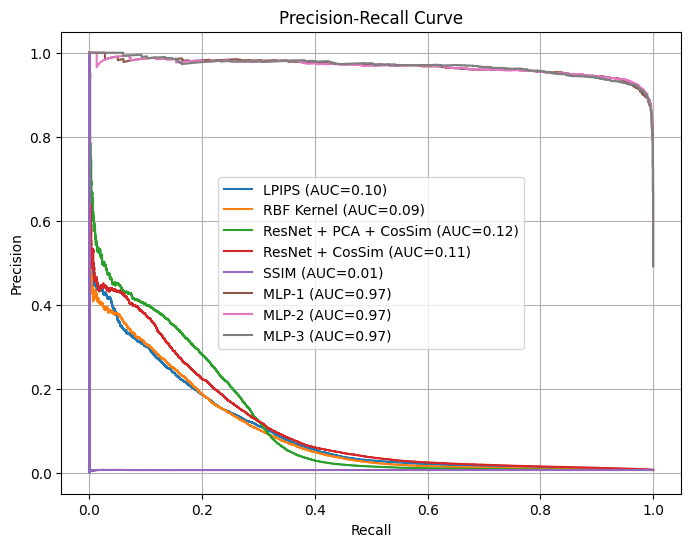

In [108]:
plot_precision_recall_curves(gt, sim_mat)